# Predictive Modeling of Housing Prices in Philadelphia

## Part 1: Modeling Philadelphia's Housing Prices

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
np.random.seed(42)

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### 1.1 Load data from the Office of Property Assessment

Use `carto2gpd` to load data for properties in Philadelphia that had their last sale during 2018.

Sources: 
- [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- [Metadata](http://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/)

In [4]:
import carto2gpd

In [5]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# The table name
table_name = "opa_properties_public"

# Only pull 2019 sales for single family residential properties
where = "sale_date >= '2019-01-01' and sale_date < '2020-01-01' and category_code_description = 'Single Family'"

# Run the query
salesRaw = carto2gpd.get(carto_url, table_name, where=where)

In [6]:
salesRaw.head()

,geometry,cartodb_id,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,type_heater,unfinished,unit,utility,view_type,year_built,year_built_estimate,zip_code,zoning,objectid
0,POINT (-75.14927 39.93033),11,None,D,"182'11"" W PHILIP",3527524,O50,ROW 3 STY MASONRY,1,Single Family,...,A,None,None,None,I,1920,None,191476037,RSA5,802024387
1,POINT (-75.14854 39.93144),23,None,0,"54'7"" E OF AMERICAN",3547465,R30,ROW B/GAR 2 STY MASONRY,1,Single Family,...,A,None,None,None,I,1960,Y,191475336,RSA5,802024329
2,POINT (-75.14721 39.93033),49,None,C,"40'4 1/2"" W HOWARD ST",3517081,O50,ROW 3 STY MASONRY,1,Single Family,...,A,None,None,None,I,1920,Y,191476128,RSA5,802024355
3,POINT (-75.14871 39.92927),102,None,C,83'W 2ND ST,3550739,O30,ROW 2 STY MASONRY,1,Single Family,...,H,None,None,None,I,1900,Y,191476003,RSA5,802024491
4,POINT (-75.14876 39.93011),116,None,A,28 FT W PHILIP,3534307,O30,ROW 2 STY MASONRY,1,Single Family,...,A,None,None,None,I,1920,Y,191476012,RSA5,802024393


In [7]:
len(salesRaw)

25955

### 1.2 Load data for census tracts and neighborhoods

Load various Philadelphia-based regions we will use in our analysis.

- Census tracts can be downloaded from: http://data.phl.opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson
- Neighborhoods can be downloaded from:
https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson


In [8]:
import esri2gpd

In [9]:
# Neighborhoods
url = "https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson"
hoods = (
    gpd.read_file(url)
    .to_crs(epsg=4326)
    .rename(columns={"mapname": "neighborhood"})
)

In [10]:
# Census tracts
url = "http://data.phl.opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson"
tracts = gpd.read_file(url)

### 1.3 Spatially join the sales data and neighborhoods/census tracts.

Perform a spatial join, such that each sale has an associated neighborhood and census tract.

**Note:** after performing the first spatial join, you will need to use the `drop()` function to remove the `index_right` column; otherwise an error will be raised on the second spatial join about duplicate columns.

In [11]:
# Join sales with hoods
salesRaw = gpd.sjoin(salesRaw, hoods, op='within')

In [12]:
# Remove index_right
salesRaw = salesRaw.drop(labels=['index_right'], axis=1)

In [13]:
# Join sales with tracts
salesRaw = gpd.sjoin(salesRaw, tracts, op='within')

### 1.4 Train a Random Forest on the sales data

In [14]:
# The feature columns we want to use
cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "neighborhood",
]

# Trim to these columns and remove NaNs
sales = salesRaw[cols].dropna()

In [15]:
# Trim very low and very high sales
valid = (sales['sale_price'] > 3000) & (sales['sale_price'] < 1e6)
sales = sales.loc[valid]

In [16]:
len(sales)

20131

Do the test/tran split:

In [17]:
# I'll use a 70/30% split
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

Setup the preprocessor that will scale and one-hot encode the sales data:

In [18]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]

# Categorical columns
cat_cols = ["exterior_condition", "neighborhood"]

In [19]:
# Set up the column transformer with two transformers
# Scale the numerical columns and one-hot 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

Set up our pipeline:

In [20]:
# Initialize the pipeline
pipe = make_pipeline(
    preprocessor, RandomForestRegressor(random_state=42)
)

Set up the grid search to optimize two hyperparameters:

In [21]:
# Make the grid of parameters to search
# NOTE: you must prepend the name of the pipeline step
model_name = "randomforestregressor"
param_grid = {
    f"{model_name}__n_estimators": [5, 20, 30, 50, 100],
    f"{model_name}__max_depth": [2, 13, 21, 33, 51, 77],
}

param_grid

{'randomforestregressor__n_estimators': [5, 20, 30, 50, 100],
 'randomforestregressor__max_depth': [2, 13, 21, 33, 51, 77]}

In [22]:
# Create the grid and use 3-fold CV
grid = GridSearchCV(pipe, param_grid, verbose=5, cv=3)

# Run the search
grid.fit(train_set, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5 
[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5, score=0.174, total=   0.1s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5 
[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5, score=0.191, total=   0.1s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5, score=0.213, total=   0.1s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20 
[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20, score=0.174, total=   0.1s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20, score=0.191, total=   0.1s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20 
[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20, score=0.213, total=   0.2s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=30 
[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=30, score=0.174, total=   0.4s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=30 
[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=30, score=0.189, total=   0.2s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=30 
[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=30, score=0.214, total=   0.2s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=50 
[CV]  randomforestregressor__max_depth=2, randomfo

[CV]  randomforestregressor__max_depth=33, randomforestregressor__n_estimators=5, score=0.560, total=   0.9s
[CV] randomforestregressor__max_depth=33, randomforestregressor__n_estimators=20 
[CV]  randomforestregressor__max_depth=33, randomforestregressor__n_estimators=20, score=0.576, total=   3.7s
[CV] randomforestregressor__max_depth=33, randomforestregressor__n_estimators=20 
[CV]  randomforestregressor__max_depth=33, randomforestregressor__n_estimators=20, score=0.587, total=   3.9s
[CV] randomforestregressor__max_depth=33, randomforestregressor__n_estimators=20 
[CV]  randomforestregressor__max_depth=33, randomforestregressor__n_estimators=20, score=0.600, total=   4.7s
[CV] randomforestregressor__max_depth=33, randomforestregressor__n_estimators=30 
[CV]  randomforestregressor__max_depth=33, randomforestregressor__n_estimators=30, score=0.579, total=   5.5s
[CV] randomforestregressor__max_depth=33, randomforestregressor__n_estimators=30 
[CV]  randomforestregressor__max_depth=33

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  8.9min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['total_livable_area',
                                                                          'total_area',
                                                                          'garage_spaces',
                                                                          'fireplaces',
                                                                          'number_of_bathrooms',
                                                                          'number_of_bedrooms',
                                                                          'number_stories']),
                                                                        ('cat',
                   

In [23]:
# The best estimator
best_estimator = grid.best_estimator_

In [24]:
# The best hyper parameters
grid.best_params_

{'randomforestregressor__max_depth': 51,
 'randomforestregressor__n_estimators': 100}

In [25]:
# Get the R2 on the test set!
best_estimator.score(test_set, y_test)

0.6063805760204916

### 2.5 Calculate the percent error of your model predictions for each sale in the test set

Fit your best model and use it to make predictions on the test set.

**Note:** this should be the percent error in terms of **sale price** or **sale price per sq ft**. You'll need to convert if you predicted the log!

In [26]:
# Make the predictions
predictions = best_estimator.predict(test_set)

# Absolute error
# NOTE: we convert from log(sale_price) to sale_price using exp()
errors = (np.exp(predictions) - np.exp(y_test)) / np.exp(y_test) * 100

In [27]:
errors.head()

16549   -61.744701
14680    29.363871
19833   -18.672173
14511   -22.510522
12760   -31.649470
Name: sale_price, dtype: float64

### 2.6 Make a data frame with percent errors and census tract info for each sale in the test set

Create a data frame that has the property geometries, census tract data, and percent errors for all of the sales in the test set.

**Notes**

- When using the "train_test_split()" function, the index of the test data frame includes the labels from the original sales data frame
- You can use this index to slice out the test data from the original sales data frame, which should include the census tract info and geometries
- Add a new column to this data frame holding the percent error data



In [28]:
# Extract out the test set data from the original data set
salesTest = salesRaw.loc[test_set.index]

# Add the percent error column
salesTest['percent_error'] =  errors

salesTest.head()

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,percent_error
16549,POINT (-75.16262 40.07149),349744,None,H,"257'111/8"" N UPSAL ST",3555139,R30,ROW B/GAR 2 STY MASONRY,1,Single Family,...,263.01,Census Tract 263.01,G5020,S,406340,0,+40.0728148,-075.1637161,10574,-61.744701
14680,POINT (-75.13007 40.02820),302803,None,None,131' N OF ASHDALE ST,3534862,O30,ROW 2 STY MASONRY,1,Single Family,...,286,Census Tract 286,G5020,S,717845,0,+40.0285757,-075.1276448,10600,29.363871
19833,POINT (-75.06209 40.06844),412535,None,E,24.175' SEC DORCAS,3506998,K11,S/D W/B GAR 1 STY MAS+OTH,1,Single Family,...,337.02,Census Tract 337.02,G5020,S,1057798,0,+40.0707532,-075.0578212,10649,-18.672173
14511,POINT (-75.12727 40.03000),308470,None,None,"137'0 1/2"" W OF 2ND",3509507,O30,ROW 2 STY MASONRY,1,Single Family,...,286,Census Tract 286,G5020,S,717845,0,+40.0285757,-075.1276448,10600,-22.510522
12760,POINT (-75.22743 39.93575),270187,None,C,157' S CHESTER AVE,3468426,O30,ROW 2 STY MASONRY,1,Single Family,...,71.01,Census Tract 71.01,G5020,S,253256,0,+39.9381580,-075.2249984,10403,-31.649470


### 2.7 Plot a map of the median percent error by census tract 

- You'll want to group your data frame of test sales by the `GEOID10` column and take the median of you percent error column
- Merge the census tract geometries back in and use geopandas to plot.

In [29]:
median_errors = tracts.merge(
    salesTest.groupby("GEOID10")["percent_error"].median().reset_index(), on="GEOID10"
)

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

/Users/nhand/opt/miniconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


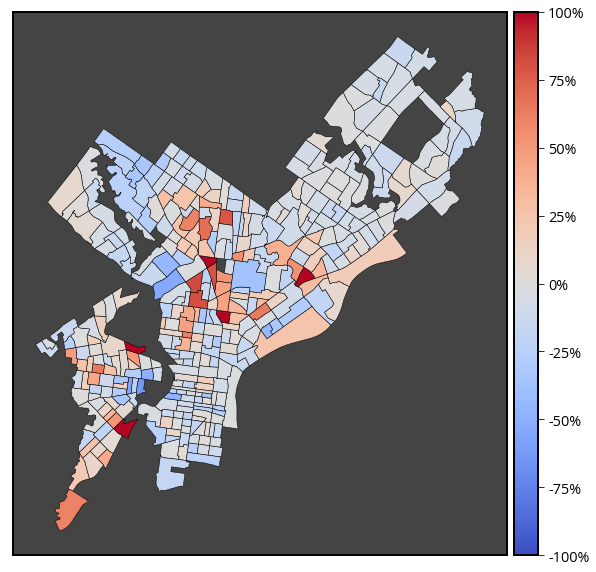

In [31]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Setup the colorbar axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot
median_errors.to_crs(epsg=2272).plot(
    ax=ax, column="percent_error", vmin=-100, vmax=100, legend=True, cax=cax, cmap='coolwarm', edgecolor='k', linewidth=0.5
)

# Format
ax.set_facecolor("#444444")
ax.set_xticks([])
ax.set_yticks([])
cax.set_yticklabels([f"{x:.0f}%" for x in cax.get_yticks()]);

**The above figure clearly shows that areas of the city with minority populations tend to be over assessed by the model.**

### 2.8 Compare the percent errors in Qualifying Census Tracts and other tracts 

[Qualifying Census Tracts](https://www.huduser.gov/portal/datasets/qct.html) are a poverty designation that HUD uses to allocate housing tax credits

- I've included a list of the census tract names that qualify in Philadelphia in 2019
- Add a new column to your dataframe of test set sales that is True/False depending on if the tract is a QCT
- Then, group by this new column and calculate the median percent error

**You should find that the algorithm's accuracy is significantly worse in these low-income, qualifying census tracts**

In [32]:
qct = ['5',
 '20',
 '22',
 '28.01',
 '30.01',
 '30.02',
 '31',
 '32',
 '33',
 '36',
 '37.01',
 '37.02',
 '39.01',
 '41.01',
 '41.02',
 '56',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '69',
 '70',
 '71.01',
 '71.02',
 '72',
 '73',
 '74',
 '77',
 '78',
 '80',
 '81.01',
 '81.02',
 '82',
 '83.01',
 '83.02',
 '84',
 '85',
 '86.01',
 '86.02',
 '87.01',
 '87.02',
 '88.01',
 '88.02',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '98.01',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '119',
 '121',
 '122.01',
 '122.03',
 '131',
 '132',
 '137',
 '138',
 '139',
 '140',
 '141',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '151.01',
 '151.02',
 '152',
 '153',
 '156',
 '157',
 '161',
 '162',
 '163',
 '164',
 '165',
 '167.01',
 '167.02',
 '168',
 '169.01',
 '169.02',
 '170',
 '171',
 '172.01',
 '172.02',
 '173',
 '174',
 '175',
 '176.01',
 '176.02',
 '177.01',
 '177.02',
 '178',
 '179',
 '180.02',
 '188',
 '190',
 '191',
 '192',
 '195.01',
 '195.02',
 '197',
 '198',
 '199',
 '200',
 '201.01',
 '201.02',
 '202',
 '203',
 '204',
 '205',
 '206',
 '208',
 '239',
 '240',
 '241',
 '242',
 '243',
 '244',
 '245',
 '246',
 '247',
 '249',
 '252',
 '253',
 '265',
 '267',
 '268',
 '271',
 '274.01',
 '274.02',
 '275',
 '276',
 '277',
 '278',
 '279.01',
 '279.02',
 '280',
 '281',
 '282',
 '283',
 '284',
 '285',
 '286',
 '287',
 '288',
 '289.01',
 '289.02',
 '290',
 '291',
 '293',
 '294',
 '298',
 '299',
 '300',
 '301',
 '302',
 '305.01',
 '305.02',
 '309',
 '311.01',
 '312',
 '313',
 '314.01',
 '314.02',
 '316',
 '318',
 '319',
 '321',
 '325',
 '329',
 '330',
 '337.01',
 '345.01',
 '357.01',
 '376',
 '377',
 '380',
 '381',
 '382',
 '383',
 '389',
 '390']

In [33]:
median_errors['qct'] = False
median_errors.loc[median_errors['NAME10'].isin(qct), 'qct'] = True

In [34]:
median_errors.groupby("qct")['percent_error'].median()

qct
False   -6.207256
True     0.701407
Name: percent_error, dtype: float64

**The non-qualifying census tracts tend to be under-assessed while qualifying tracts tend to be over-assessed.**